In [ ]:
import os
import json
import gzip
import shutil
import torch
import numpy as np
import matplotlib.pyplot as plt

from karhu.utils_input import *
from karhu.models import CNN_gmax

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
model_dir = "../model"

# Load scaling parameters
with open(os.path.join(model_dir, "scaling_params.json",), "r", encoding="utf-8",) as f:
    scaling_params = json.load(f)

# Load model
model = CNN_gmax()
model.load_state_dict(
    torch.load(os.path.join(model_dir, "model.pt"), weights_only=True,)
)
model.eval()

n_profile_points = 64
x_1 = np.linspace(1e-5, 1, n_profile_points) ** (1 / 4)

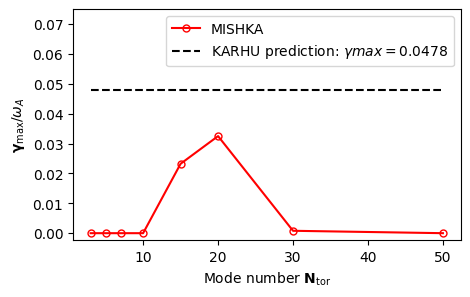

In [6]:
"""
The data directory in the example folder contains the HELENA files needed to construct the model input.
You can replace this with your own HELENA equilibrium files. The model predicts the maximum growth rate of
the given equilibrium.
The reference values are the mode number (Ntor) specific growth rates calculated by MISHKA for the same equilibrium.
"""
rundir = "./data"

with gzip.open(os.path.join(rundir, 'fort.12.gz'), 'rb') as f_in:
    with open(os.path.join(rundir, 'fort.12'), 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

x = get_model_input(
    filename_f10=os.path.join(rundir, 'fort.10'), 
    filename_f12=os.path.join(rundir, 'fort.12'), 
    filename_f20=os.path.join(rundir, 'fort.20'), 
    x_1=x_1, 
    n_profile_points=n_profile_points,)

x = scale_model_input(x, scaling_params)
y_pred = model(*x)
y_pred = descale_minmax(
    y_pred.item(),
    scaling_params["growthrate"][0],
    scaling_params["growthrate"][1],
)
y_pred = 0.0 if y_pred <= 0.0 else y_pred

y_true = [0.0, 0.0, 0.0, 0.0, np.sqrt(0.5405E-03), np.sqrt(0.1058E-02), 0.8027E-03, 0.0]
x_true = [3, 5, 7, 10, 15, 20, 30, 50,]

fig_prediction, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.plot(x_true, y_true, ".-", c="red", markersize=10, fillstyle="none", label="MISHKA",)
plt.hlines(y=y_pred, xmin=3, xmax=50, colors='black', linestyles='dashed', label=f'KARHU prediction: $\gamma max = ${y_pred:.4f}')
plt.xlabel(r"Mode number $\mathbf{N_{\text{tor}}}$")
plt.ylabel(r"$\mathbf{\gamma_{\text{max}}}/\omega_A$")
plt.ylim(None, 0.075)
plt.legend()
